# **Data Analysis**

#### *Dataset : Housing Price Data*


### Importing Dependencies

In [1]:
# Importing Pacakges
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configuring libs
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 400)
%matplotlib inline
sns.set()

print('Dependencies has been imported successfully.')

Dependencies has been imported successfully.


### Importing Dataset

There are an extensive number of features, so they've been described in the .txt file (Description.txt)[]

In [2]:
# Reading Dataset

# Train Data
df_train = pd.read_csv(r'assets/dataset/Housing_Price_Train.csv')
df_train.head()
print(f'Training Dataset has been read successfully.\nRows : {df_train.shape[0]}\nColumns : {df_train.shape[1]}')

Training Dataset has been read successfully.
Rows : 1460
Columns : 81


In [3]:
# Checking for the presence of duplicate entry
df_train.duplicated('Id').sum()

0

In [4]:
# Deleting 'Id' Column
del df_train['Id']

In [5]:
# Creating a function that will track quantitative and qualitative data
def count_cols(dataframe):
    '''
    This function returns the counts of numeric and categorical data columns. 
    '''
    
    # creating dataframe with numeric data
    quantitative_cols = dataframe.select_dtypes(include=[np.number])

    # creating dataframe with categorical data
    qualitative_cols = dataframe.select_dtypes(exclude=[np.number])

    # printing the counts of numeric and categorical data
    return [f'There are {quantitative_cols.shape[1]} numeric columns and \
{qualitative_cols.shape[1]} categorical columns.', quantitative_cols, qualitative_cols]

In [6]:
print(count_cols(df_train)[0])

There are 37 numeric columns and 43 categorical columns.


### Null or Missing Value

In [7]:
# missing value check
# counting missing values for each columns
missing_cols = (df_train.isnull().sum()*100/len(df_train)).sort_values(ascending=False)

# listing missing values of columns > 0
print(missing_cols[missing_cols>0])

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageCond       5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtCond         2.534247
BsmtQual         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64


We can see the list of columns having missing values, we will not drop or replace Nan with random guess.<br />
Instead lets analyze the behavious of data and realtions.

### Numerical Feature Analysis

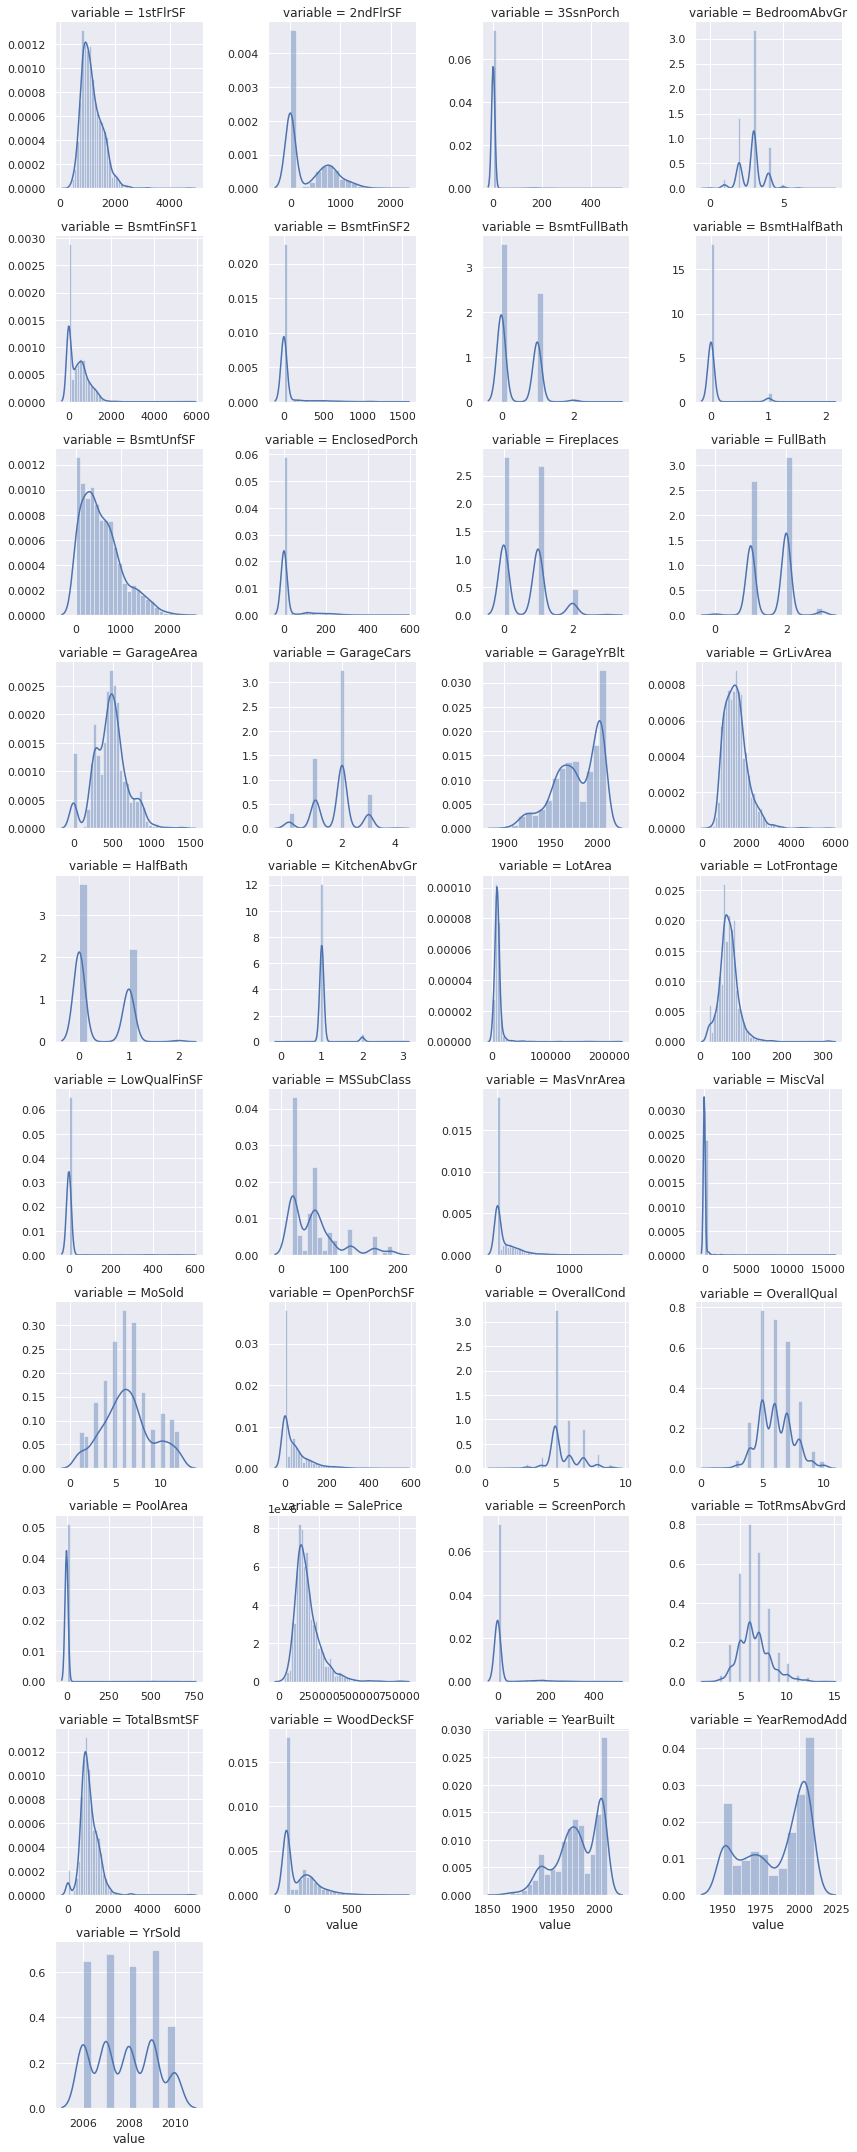

In [8]:
# Creating a distribution plot of all quantitative variable w.r.t. 'SalePrice'
melt_df = pd.melt(df_train, value_vars=sorted(count_cols(df_train)[1]))
sf = sns.FacetGrid(melt_df, col='variable', col_wrap=4, sharex=False, sharey=False)
sf.map(sns.distplot, 'value')
plt.show()

Above we can see that there are few plot which aren't continuous and acts as categorical varirable

- MoSold
- OverallQual 

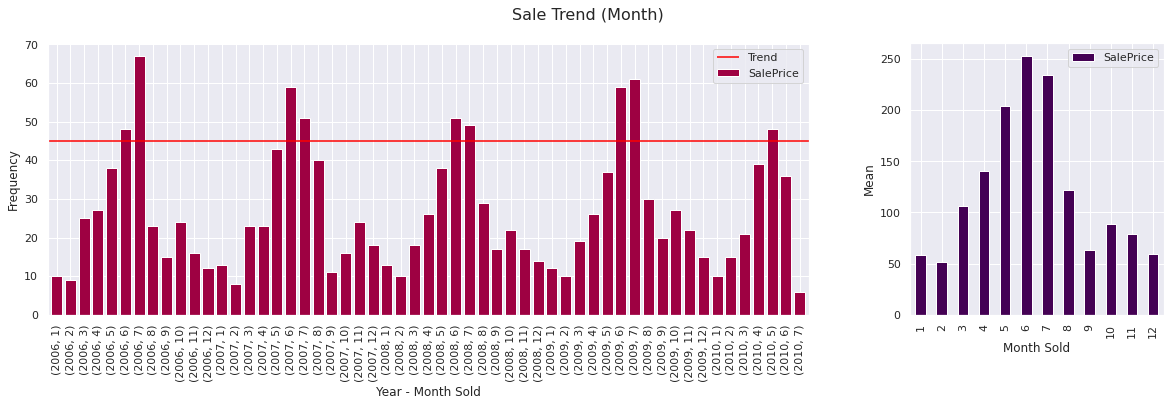

In [9]:
# Display SalePrice trend in month of specific year
fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5), gridspec_kw={'width_ratios': [3, 1]})
ax11 = df_train.groupby(['YrSold', 'MoSold']).SalePrice.count().plot(kind='bar', colormap='Spectral', width=0.8, ax=ax1)
ax11.hlines(y=45, xmin=-1, xmax=100, color='red', label='Trend')
ax11.set(xlabel="Year - Month Sold", ylabel="Frequency")
ax11.legend()

ax12 = df_train.groupby(['MoSold']).SalePrice.count().plot(kind='bar', colormap='viridis', width=0.5, ax=ax2)
ax12.set(xlabel="Month Sold", ylabel="Mean")
ax12.legend()

fig.suptitle("Sale Trend (Month)",fontsize=16)

plt.show()

### Replacing Nan Values

After analyzing the pattern in data of qunatitative variable we found that there are some columns which provides user to fill non related data with None or NA. So, we can consider that user was not willing to or wasn't eligible to provide the data. Therefore, we will fill those `Nan` columns with `NA` or `None`.

For other column which don't lies in above scenario we will replace them with `mean` and `mode`.

In [10]:
# Replacing Nan value

# For below column with missing values we have an option to replace the missing values wiht 'NA'
# as 'NA' is a choice available for readings of those columns
# So, we consider that 'Nan' values was something that wasn't applicable for the respective house.
for col in ['Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu', 'GarageCond', 'GarageType', 'GarageFinish', 'GarageQual', 'BsmtExposure', 'BsmtFinType2', 'BsmtCond', 'BsmtQual', 'BsmtFinType1', ]:
    df_train[col].fillna('NA', inplace=True)
    
# Similar to previous case, this column has choice 'None' equivalent to 'NA'
# So, we consider to replace it with 'None'
df_train['MasVnrType'].fillna('None', inplace=True)

# Filling 'Nan' values of below listed column with mean
df_train['LotFrontage'] = df_train.groupby('Street')['LotFrontage'].transform(lambda x:x.fillna(x.mean()))
df_train['MasVnrArea'] = df_train.groupby('MasVnrType')['MasVnrArea'].transform(lambda x:x.fillna(x.mean()))
df_train['GarageYrBlt'] = df_train.groupby('GarageQual')['GarageYrBlt'].transform(lambda x:x.fillna(x.mode()))

# Converting behaviour of 'MoSold' from numerical to categorical
df_train['MoSold'] = df_train['MoSold'].apply(lambda x: str(x))

Lets add some new columns into dataframe using previous columns.<br>
For e.g. :
   - HouseAge & GarageAge : This will define how many year old the house & garage is.
   - TotalBath : We can sum up the total bathroom available in the house.
   - 2FlrBld : It tells whether the house has 2 floor or not.
     and many other.

In [11]:
# Adding new columns

# How many year old the houses are ?
df_train['HouseAge'] = df_train['YrSold'] - df_train['YearRemodAdd'] 

# How many year old the garages are ?
df_train['GarageAge'] = df_train['YrSold'] - df_train['GarageYrBlt']
# Replacing leftover 'Nan' values with 0, for the houses that do not have garage
df_train['GarageAge'].fillna(0, inplace=True) 

# Consdering Total Bathrooms Available in the house
df_train['TotalBath'] = df_train['BsmtFullBath'] + df_train['FullBath'] + df_train['BsmtHalfBath']*0.5 + df_train['HalfBath']*0.5

# Considering Total Porch Square Ft.
df_train['TotalPorchSF'] = df_train['OpenPorchSF'] + df_train['EnclosedPorch'] + df_train['3SsnPorch'] + df_train['ScreenPorch']

# Checking if house has Multiple Floor
df_train['2FlrBld'] = df_train['2ndFlrSF'].apply(lambda x: 0 if x==0 else 1)

# Checking if Basement is Available with house
df_train['BsmtAvailable'] = df_train['BsmtExposure'].apply(lambda x: 0 if x=='NA' else 1)

Lets have look at change in price with respect to house and garage age.

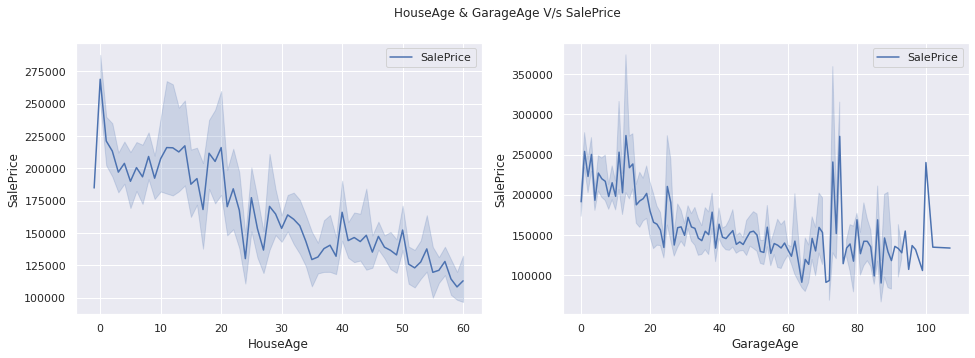

In [12]:
# Plotting relation between HouseAge & GarageAge w.r.t. SalePrice

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,5))

sns.lineplot(x='HouseAge', y='SalePrice', data=df_train, label = 'SalePrice', ax=ax1)
sns.lineplot(x='GarageAge', y='SalePrice', data=df_train, label = 'SalePrice', ax=ax2)

fig.suptitle('HouseAge & GarageAge V/s SalePrice')
plt.legend()
plt.show()

As we have used some column to create new column, now we can delete the old columns.<br />
In below cell we will drop the columns that isn't required<br />

In [13]:
# List of column names need to be dropped as non required / repetational
drop_col = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
            '1stFlrSF', '2ndFlrSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
            'HalfBath', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
            'YrSold', 'BsmtExposure', 'Electrical']

# List of column names for which dummy var is to be created
dummy_col = ['MoSold', 'GarageType', 
             'GarageFinish', 'BsmtFinType2', 'BsmtFinType1']

# Droping columns mentioned in `drop_col` variable
df_train.drop(drop_col, axis=1, inplace=True)

# Dropping column with leftover Nan value (Only one row with Nan in Electrical Column!) 
df_train.dropna(inplace=True)

# Reseting the index number after dropping all the missing values
df_train.reset_index(drop=True, inplace=True)

new_df = pd.concat([df_train, pd.get_dummies(df_train[dummy_col], drop_first=True)], axis=1)
new_df.drop(dummy_col, axis=1, inplace=True)

Checking missing value in dataset

In [14]:
# Missing value check
# Counting missing values for each columns
missing_cols = (df_train.isnull().sum()*100/len(df_train)).sort_values(ascending=False)

# Listing missing values of columns > 0
print(missing_cols[missing_cols>0])

Series([], dtype: float64)


In [15]:
new_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,TotalBsmtSF,Heating,HeatingQC,CentralAir,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,SaleType,SaleCondition,SalePrice,HouseAge,GarageAge,TotalBath,TotalPorchSF,2FlrBld,BsmtAvailable,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NA,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NA,BsmtFinType1_Rec,BsmtFinType1_Unf
0,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,856,GasA,Ex,Y,0,1710,3,1,Gd,8,Typ,0,NA,2,548,TA,TA,Y,0,0,NA,NA,NA,0,WD,Normal,208500,5,5.0,3.5,61,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
1,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,1262,GasA,Ex,Y,0,1262,3,1,TA,6,Typ,1,TA,2,460,TA,TA,Y,298,0,NA,NA,NA,0,WD,Normal,181500,31,31.0,2.5,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,920,GasA,Ex,Y,0,1786,3,1,Gd,6,Typ,1,TA,2,608,TA,TA,Y,0,0,NA,NA,NA,0,WD,Normal,223500,6,7.0,3.5,42,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
3,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,756,GasA,Gd,Y,0,1717,3,1,Gd,7,Typ,1,Gd,3,642,TA,TA,Y,0,0,NA,NA,NA,0,WD,Abnorml,140000,36,8.0,2.0,307,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,1145,GasA,Ex,Y,0,2198,4,1,Gd,9,Typ,1,TA,3,836,TA,TA,Y,192,0,NA,NA,NA,0,WD,Normal,250000,8,8.0,3.5,84,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0


#### Summarizing data

In [16]:
# Printing summary of dataframe 'new_df'
new_df.describe().tail(5)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,TotalBsmtSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,PoolArea,MiscVal,SalePrice,HouseAge,GarageAge,TotalBath,TotalPorchSF,2FlrBld,BsmtAvailable,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NA,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NA,BsmtFinType1_Rec,BsmtFinType1_Unf
min,20.0,21.000000,1300.0,1.0,1.0,0.00,0.00,0.0,334.00,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,34900.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,20.0,60.000000,7553.5,5.0,5.0,0.00,795.75,0.0,1129.50,2.0,1.0,5.0,0.0,1.0,334.5,0.0,0.0,0.0,129975.0,4.0,4.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,50.0,69.985786,9478.5,6.0,5.0,0.00,991.50,0.0,1464.00,3.0,1.0,6.0,1.0,2.0,480.0,0.0,0.0,0.0,163000.0,14.0,23.5,2.0,48.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,70.0,79.000000,11601.5,7.0,6.0,164.25,1298.25,0.0,1776.75,3.0,1.0,7.0,1.0,2.0,576.0,168.0,0.0,0.0,214000.0,41.0,46.0,2.5,136.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
max,190.0,313.000000,215245.0,10.0,9.0,1600.00,6110.00,572.0,5642.00,8.0,3.0,14.0,3.0,4.0,1418.0,857.0,738.0,15500.0,755000.0,60.0,107.0,6.0,1027.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


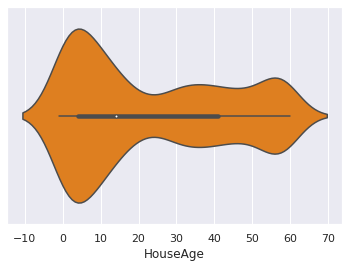

In [17]:
# range and frequency of HouseAge
sns.violinplot(new_df.HouseAge, palette="afmhot_r")
plt.show()

Through above graph we know that there are misleading entries of House data. (Age cannot be negative)

In [18]:
# Dropping row with negative 'HouseAge' value
new_df.drop(index = new_df[new_df.HouseAge < 0].index, inplace=True)

# Resetting index
new_df.reset_index(drop=True, inplace=True)

### Feature Selection (Quantitaive Feature)

**Finding Correlation**

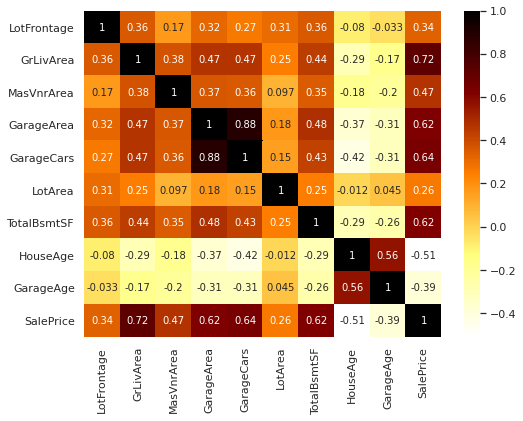

In [19]:
plt.figure(figsize=(8, 6))

# Calclating correlation in features
num_corr = new_df[['LotFrontage', 'GrLivArea', 'MasVnrArea', 'GarageArea', 'GarageCars', 'LotArea', 'TotalBsmtSF', 'HouseAge', 'GarageAge', 'SalePrice']].corr()

# Plotting correlation
sns.heatmap(num_corr, annot=True, cmap="afmhot_r")
plt.show()

**Multicollinearity**<br>
Multicollinearity is the occurrence of high intercorrelations among two or more independent variables in a multiple regression model. In general, multicollinearity can lead to wider confidence intervals that produce less reliable probabilities in terms of the effect of independent variables in a model.

In the above heatmap plot it can be seen that,
 - `HouseAge` and `GarageAge`
 - `GarageCars` and `GarageArea`

are correlated.

So we are going to drop one of each pairs. We will compare the correlation of pairs with respect to `SalePrice`.
One which has high correlation with `SalePrice` will be stored for further use and one which has low correlation will be dropped.

In [20]:
# Dropping column with Multi-colinearity
new_df.drop(['GarageAge', 'GarageArea'], axis=1, inplace=True)

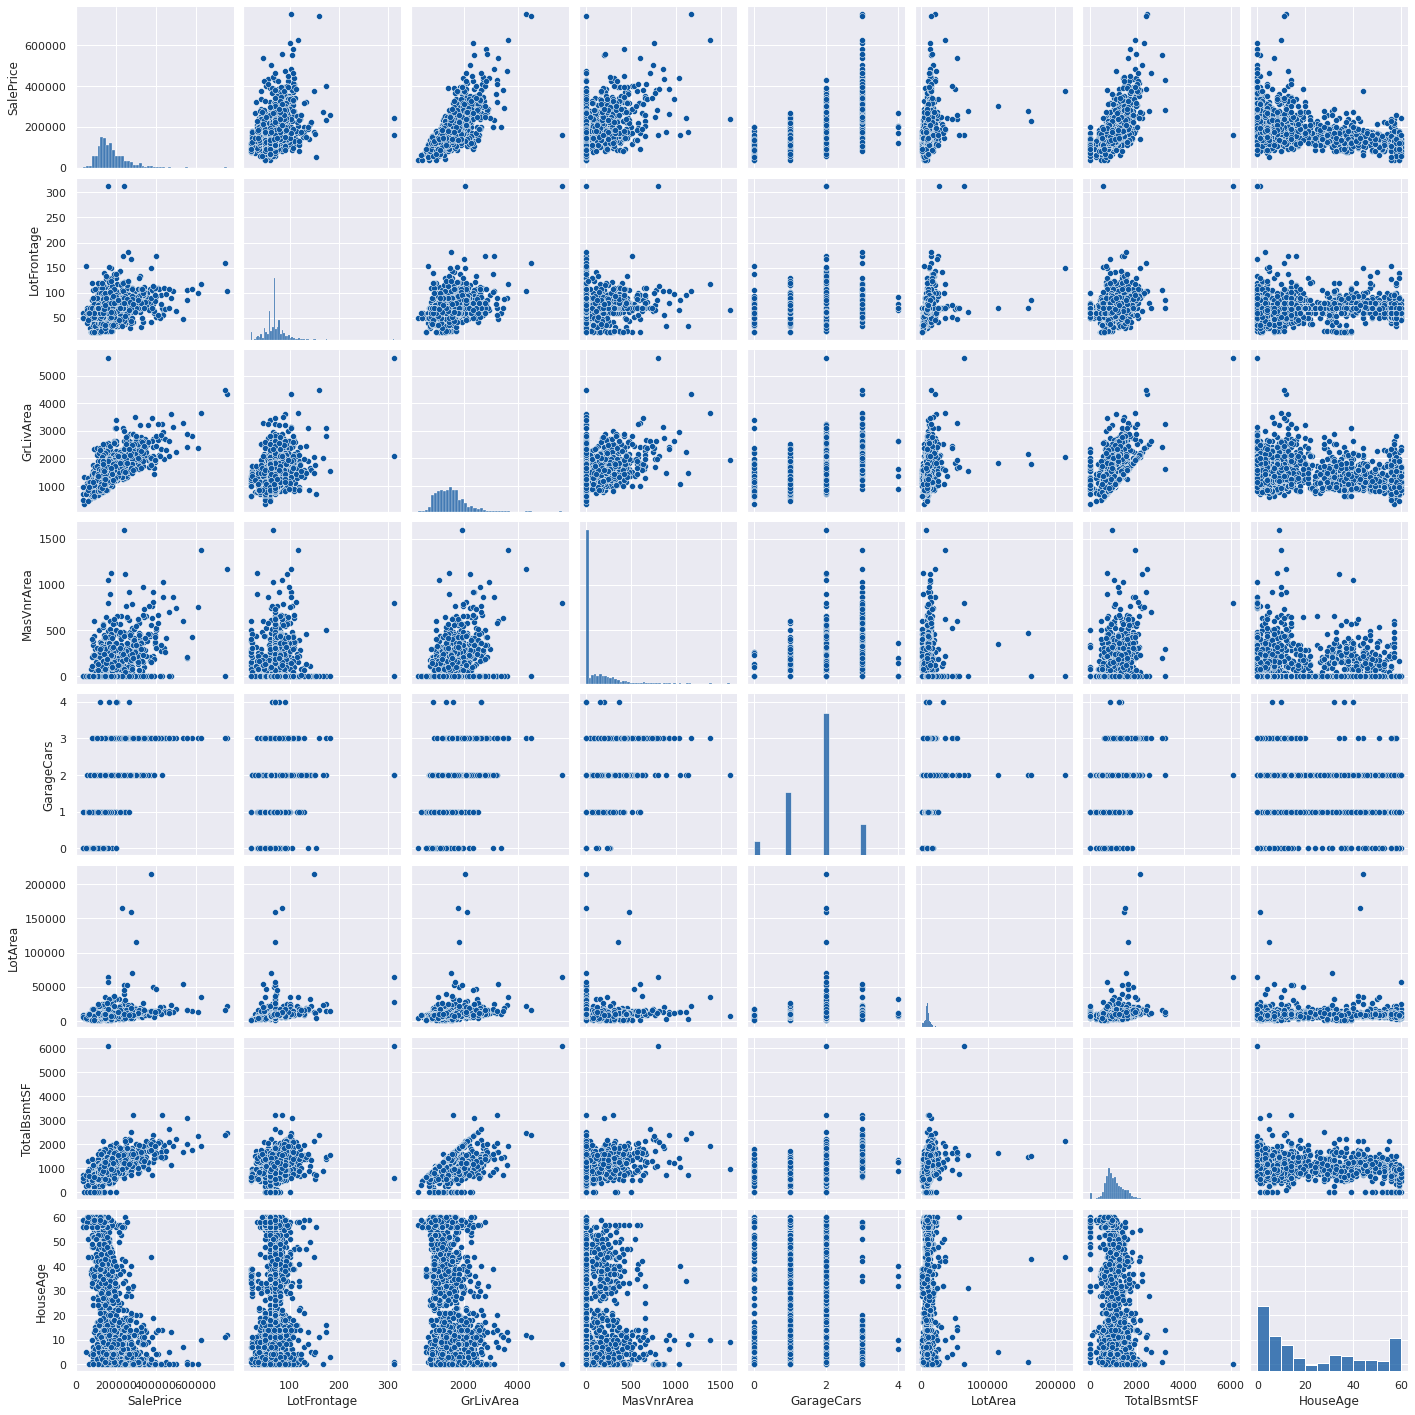

In [21]:
pplot = new_df[['SalePrice', 'LotFrontage', 'GrLivArea', 'MasVnrArea', 'GarageCars', 'LotArea', 'TotalBsmtSF', 'HouseAge']]

sns.set_palette("Blues_r")

sns.pairplot(pplot)
plt.show()

In [22]:
# Listing the index of DataFrame containing outlier

print(new_df['GrLivArea'].sort_values()[-2:].index, 
'\n',new_df['LotFrontage'].sort_values()[-2:].index,
'\n',new_df['GarageCars'].sort_values()[-5:].index,
'\n',new_df['TotalBsmtSF'].sort_values()[-1:].index,
'\n',new_df['MasVnrArea'].sort_values()[-1:].index,
'\n',new_df[(new_df['MasVnrArea']<500) & (new_df['SalePrice'] > 600000)].index)

Int64Index([1181, 1297], dtype='int64') 
 Int64Index([933, 1297], dtype='int64') 
 Int64Index([1349, 746, 1189, 1339, 420], dtype='int64') 
 Int64Index([1297], dtype='int64') 
 Int64Index([297], dtype='int64') 
 Int64Index([1181], dtype='int64')


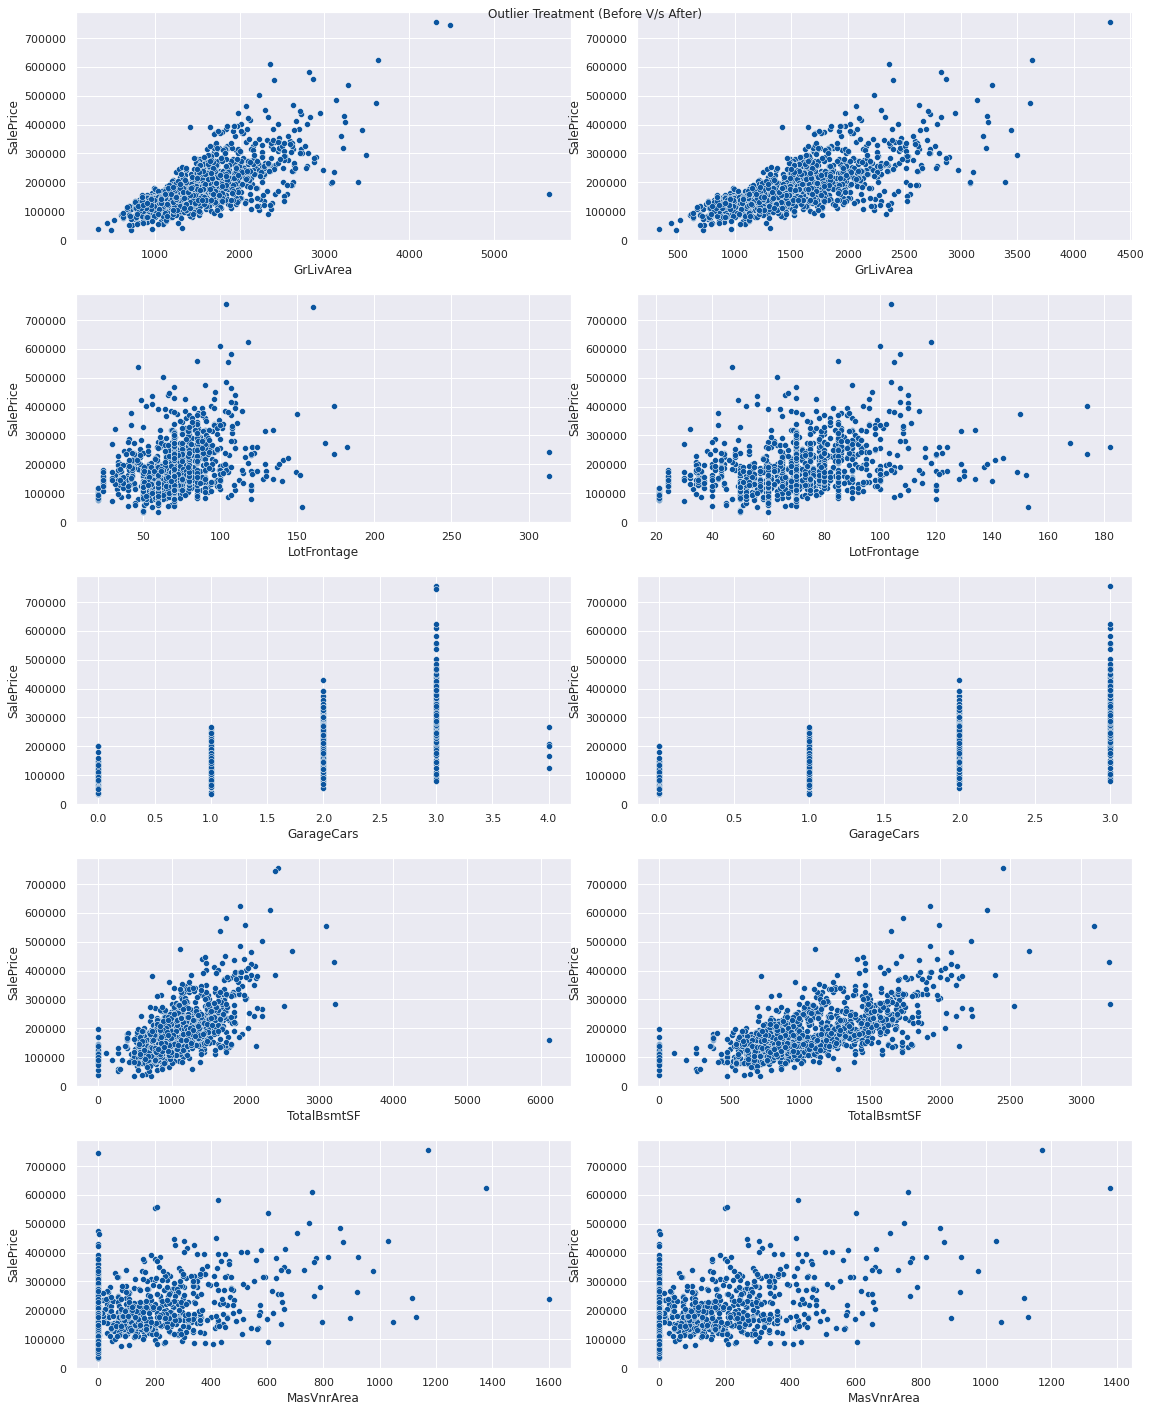

In [23]:
# Plotting scatterplot
fig, ((ax1,ax2), (ax3,ax4), (ax5,ax6), (ax7,ax8), (ax9,ax10)) = plt.subplots(5, 2, figsize=(16, 20))
fig.tight_layout(pad=3)

# Before outlier value treatment
sns.scatterplot(x = new_df['GrLivArea'], y = new_df['SalePrice'], palette="Set3", ax = ax1)
sns.scatterplot(x = new_df['LotFrontage'], y = new_df['SalePrice'], palette="Set3", ax = ax3)
sns.scatterplot(x = new_df['GarageCars'], y = new_df['SalePrice'], palette="Set3", ax = ax5)
sns.scatterplot(x = new_df['TotalBsmtSF'], y = new_df['SalePrice'], palette="Set3", ax = ax7)
sns.scatterplot(x = new_df['MasVnrArea'], y = new_df['SalePrice'], palette="Set3", ax = ax9)

new_df.drop(index = [1181, 1297, 933, 1349, 746, 1189, 1339, 420, 297], inplace = True)
new_df.reset_index(drop=True, inplace=True)

# After outlier value treatment
sns.scatterplot(x = new_df['GrLivArea'], y = new_df['SalePrice'], palette="Set3", ax = ax2)
sns.scatterplot(x = new_df['LotFrontage'], y = new_df['SalePrice'], palette="Set3", ax = ax4)
sns.scatterplot(x = new_df['GarageCars'], y = new_df['SalePrice'], palette="Set3", ax = ax6)
sns.scatterplot(x = new_df['TotalBsmtSF'], y = new_df['SalePrice'], palette="Set3", ax = ax8)
sns.scatterplot(x = new_df['MasVnrArea'], y = new_df['SalePrice'], palette="Set3", ax = ax10)

fig.suptitle("Outlier Treatment (Before V/s After)")

plt.show()

In [24]:
# Below we list few row of quantitative data from our dataset
count_cols(new_df)[1].head(5)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,TotalBsmtSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,WoodDeckSF,PoolArea,MiscVal,SalePrice,HouseAge,TotalBath,TotalPorchSF,2FlrBld,BsmtAvailable,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NA,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NA,BsmtFinType1_Rec,BsmtFinType1_Unf
0,60,65.0,8450,7,5,196.0,856,0,1710,3,1,8,0,2,0,0,0,208500,5,3.5,61,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
1,20,80.0,9600,6,8,0.0,1262,0,1262,3,1,6,1,2,298,0,0,181500,31,2.5,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,60,68.0,11250,7,5,162.0,920,0,1786,3,1,6,1,2,0,0,0,223500,6,3.5,42,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
3,70,60.0,9550,7,5,0.0,756,0,1717,3,1,7,1,3,0,0,0,140000,36,2.0,307,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,60,84.0,14260,8,5,350.0,1145,0,2198,4,1,9,1,3,192,0,0,250000,8,3.5,84,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0


### Normalizing data

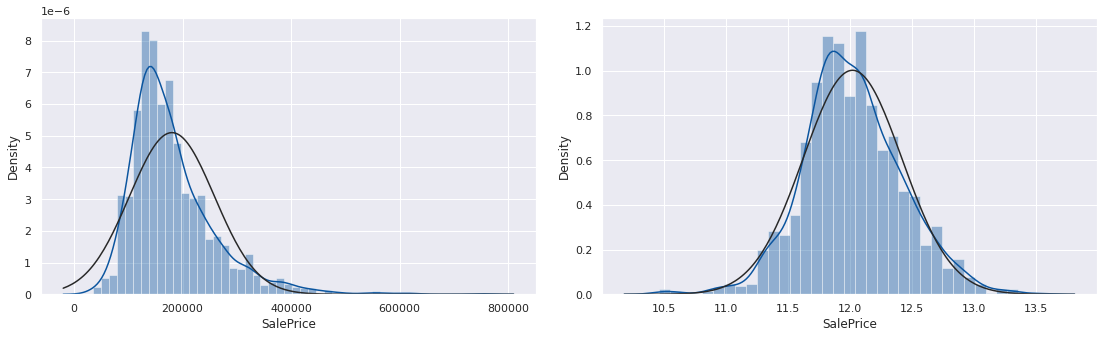

In [25]:
from scipy.stats import norm

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.tight_layout(pad=3)

# Before Normalizing
sns.distplot(new_df['SalePrice'], kde=True, fit=norm, ax = ax1)

# After Normalizing
new_df['SalePrice'] = np.log(new_df.SalePrice)
sns.distplot(new_df['SalePrice'], kde=True, fit=norm, ax = ax2)

plt.show()

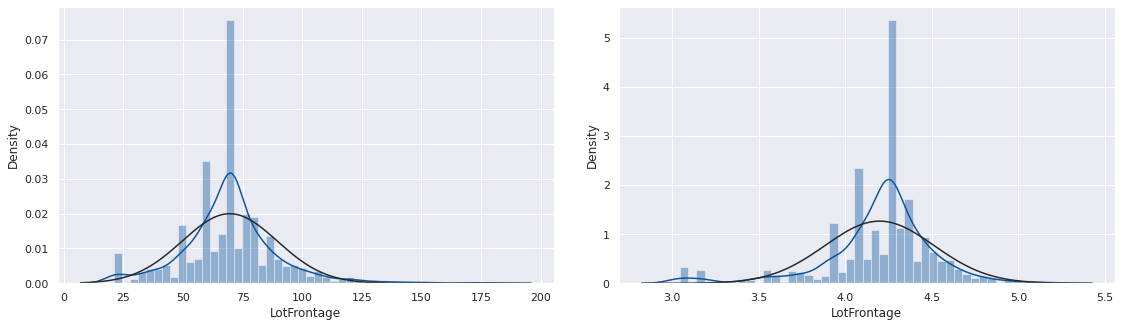

In [26]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.tight_layout(pad=3)

# Before Normalizing
sns.distplot(new_df['LotFrontage'], kde=True, fit=norm, ax = ax1)

# After Normalizing
new_df['LotFrontage'] = np.log(new_df.LotFrontage)
sns.distplot(new_df['LotFrontage'], kde=True, fit=norm, ax = ax2)

plt.show()

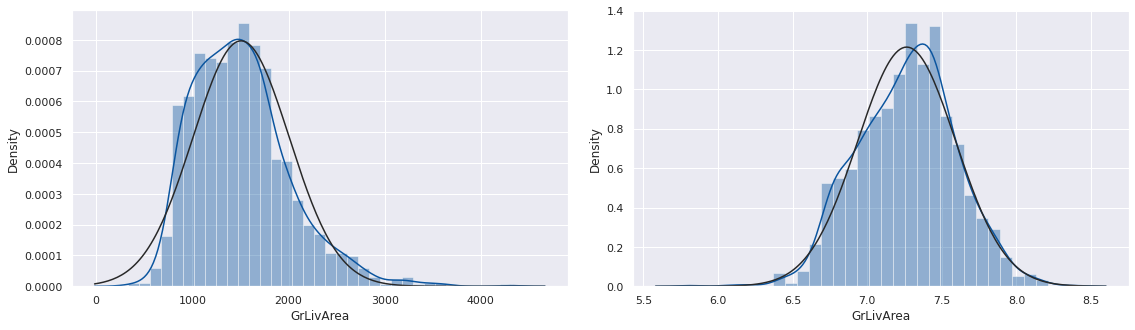

In [27]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.tight_layout(pad=3)

# Before Normalizing
sns.distplot(new_df['GrLivArea'], kde=True, fit=norm, ax = ax1)

# After Normalizing
new_df['GrLivArea'] = np.log(new_df.GrLivArea)
sns.distplot(new_df['GrLivArea'], kde=True, fit=norm, ax = ax2)

plt.show()

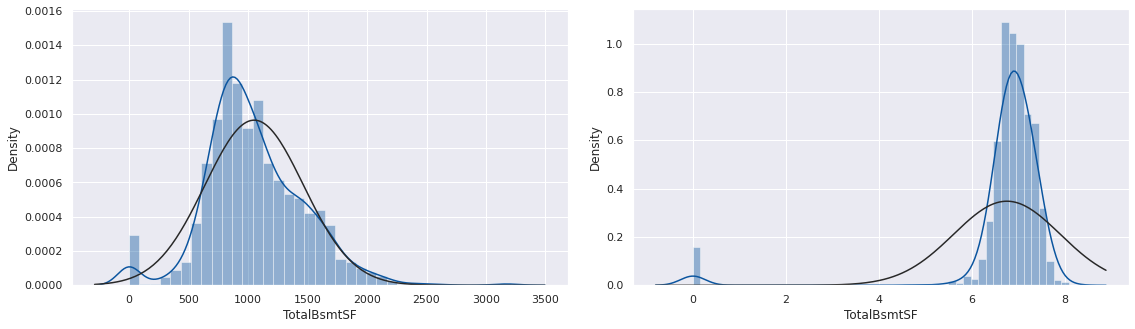

In [28]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.tight_layout(pad=3)

sns.distplot(new_df['TotalBsmtSF'], kde=True, fit=norm, ax = ax1)
# new_df['TotalBsmtSF'] = np.log1p(new_df.TotalBsmtSF)
sns.distplot(np.log1p(new_df.TotalBsmtSF), kde=True, fit=norm, ax = ax2)

plt.show()

### Pearson Correlation

In [29]:
from scipy import stats

columnss = list(count_cols(df_train)[1].columns)
columnss.remove('SalePrice')
columnss.remove('GarageArea')
columnss.remove('GarageAge')

for count, col in enumerate(columnss):
    pear_coef, p_value = stats.pearsonr(new_df[col], new_df['SalePrice'])
    if p_value < 0.001:
        pv = '< 0.001 (Accept)'
    elif p_value < 0.05:
        pv = '< 0.05  (Accept)'
    elif p_value <= 0.1:
        pv = '< 0.1   (Accept)'
    else:
        pv = '> 0.1   (Reject)'
    print(f"{count:2}. {col:14} :  Pearson coef = {pear_coef:25}  |  p-value = {p_value:25}  | {pv:<}")

 0. MSSubClass     :  Pearson coef =       -0.0757363279443462  |  p-value =      0.003906541339759347  | < 0.05  (Accept)
 1. LotFrontage    :  Pearson coef =        0.3451935523981973  |  p-value =     7.712298317211592e-42  | < 0.001 (Accept)
 2. LotArea        :  Pearson coef =        0.2605000747368347  |  p-value =     6.395922522067783e-24  | < 0.001 (Accept)
 3. OverallQual    :  Pearson coef =        0.8213475397305268  |  p-value =                       0.0  | < 0.001 (Accept)
 4. OverallCond    :  Pearson coef =      -0.03722758173334961  |  p-value =       0.15652600770226363  | > 0.1   (Reject)
 5. MasVnrArea     :  Pearson coef =       0.44073017483065413  |  p-value =      5.85867559668283e-70  | < 0.001 (Accept)
 6. TotalBsmtSF    :  Pearson coef =        0.6459955616366162  |  p-value =   4.8695371206712046e-172  | < 0.001 (Accept)
 7. LowQualFinSF   :  Pearson coef =      -0.03760766475392914  |  p-value =        0.1523360837720309  | > 0.1   (Reject)
 8. GrLivArea   

In [30]:
# drop pearson non significant columns
new_df.drop(['OverallCond', 'LowQualFinSF', 'PoolArea', 'MiscVal'], axis=1, inplace=True)

### Categorical Feature Analysis

In [31]:
# Available qualitative columns
qualitative_data = count_cols(new_df)[2].columns

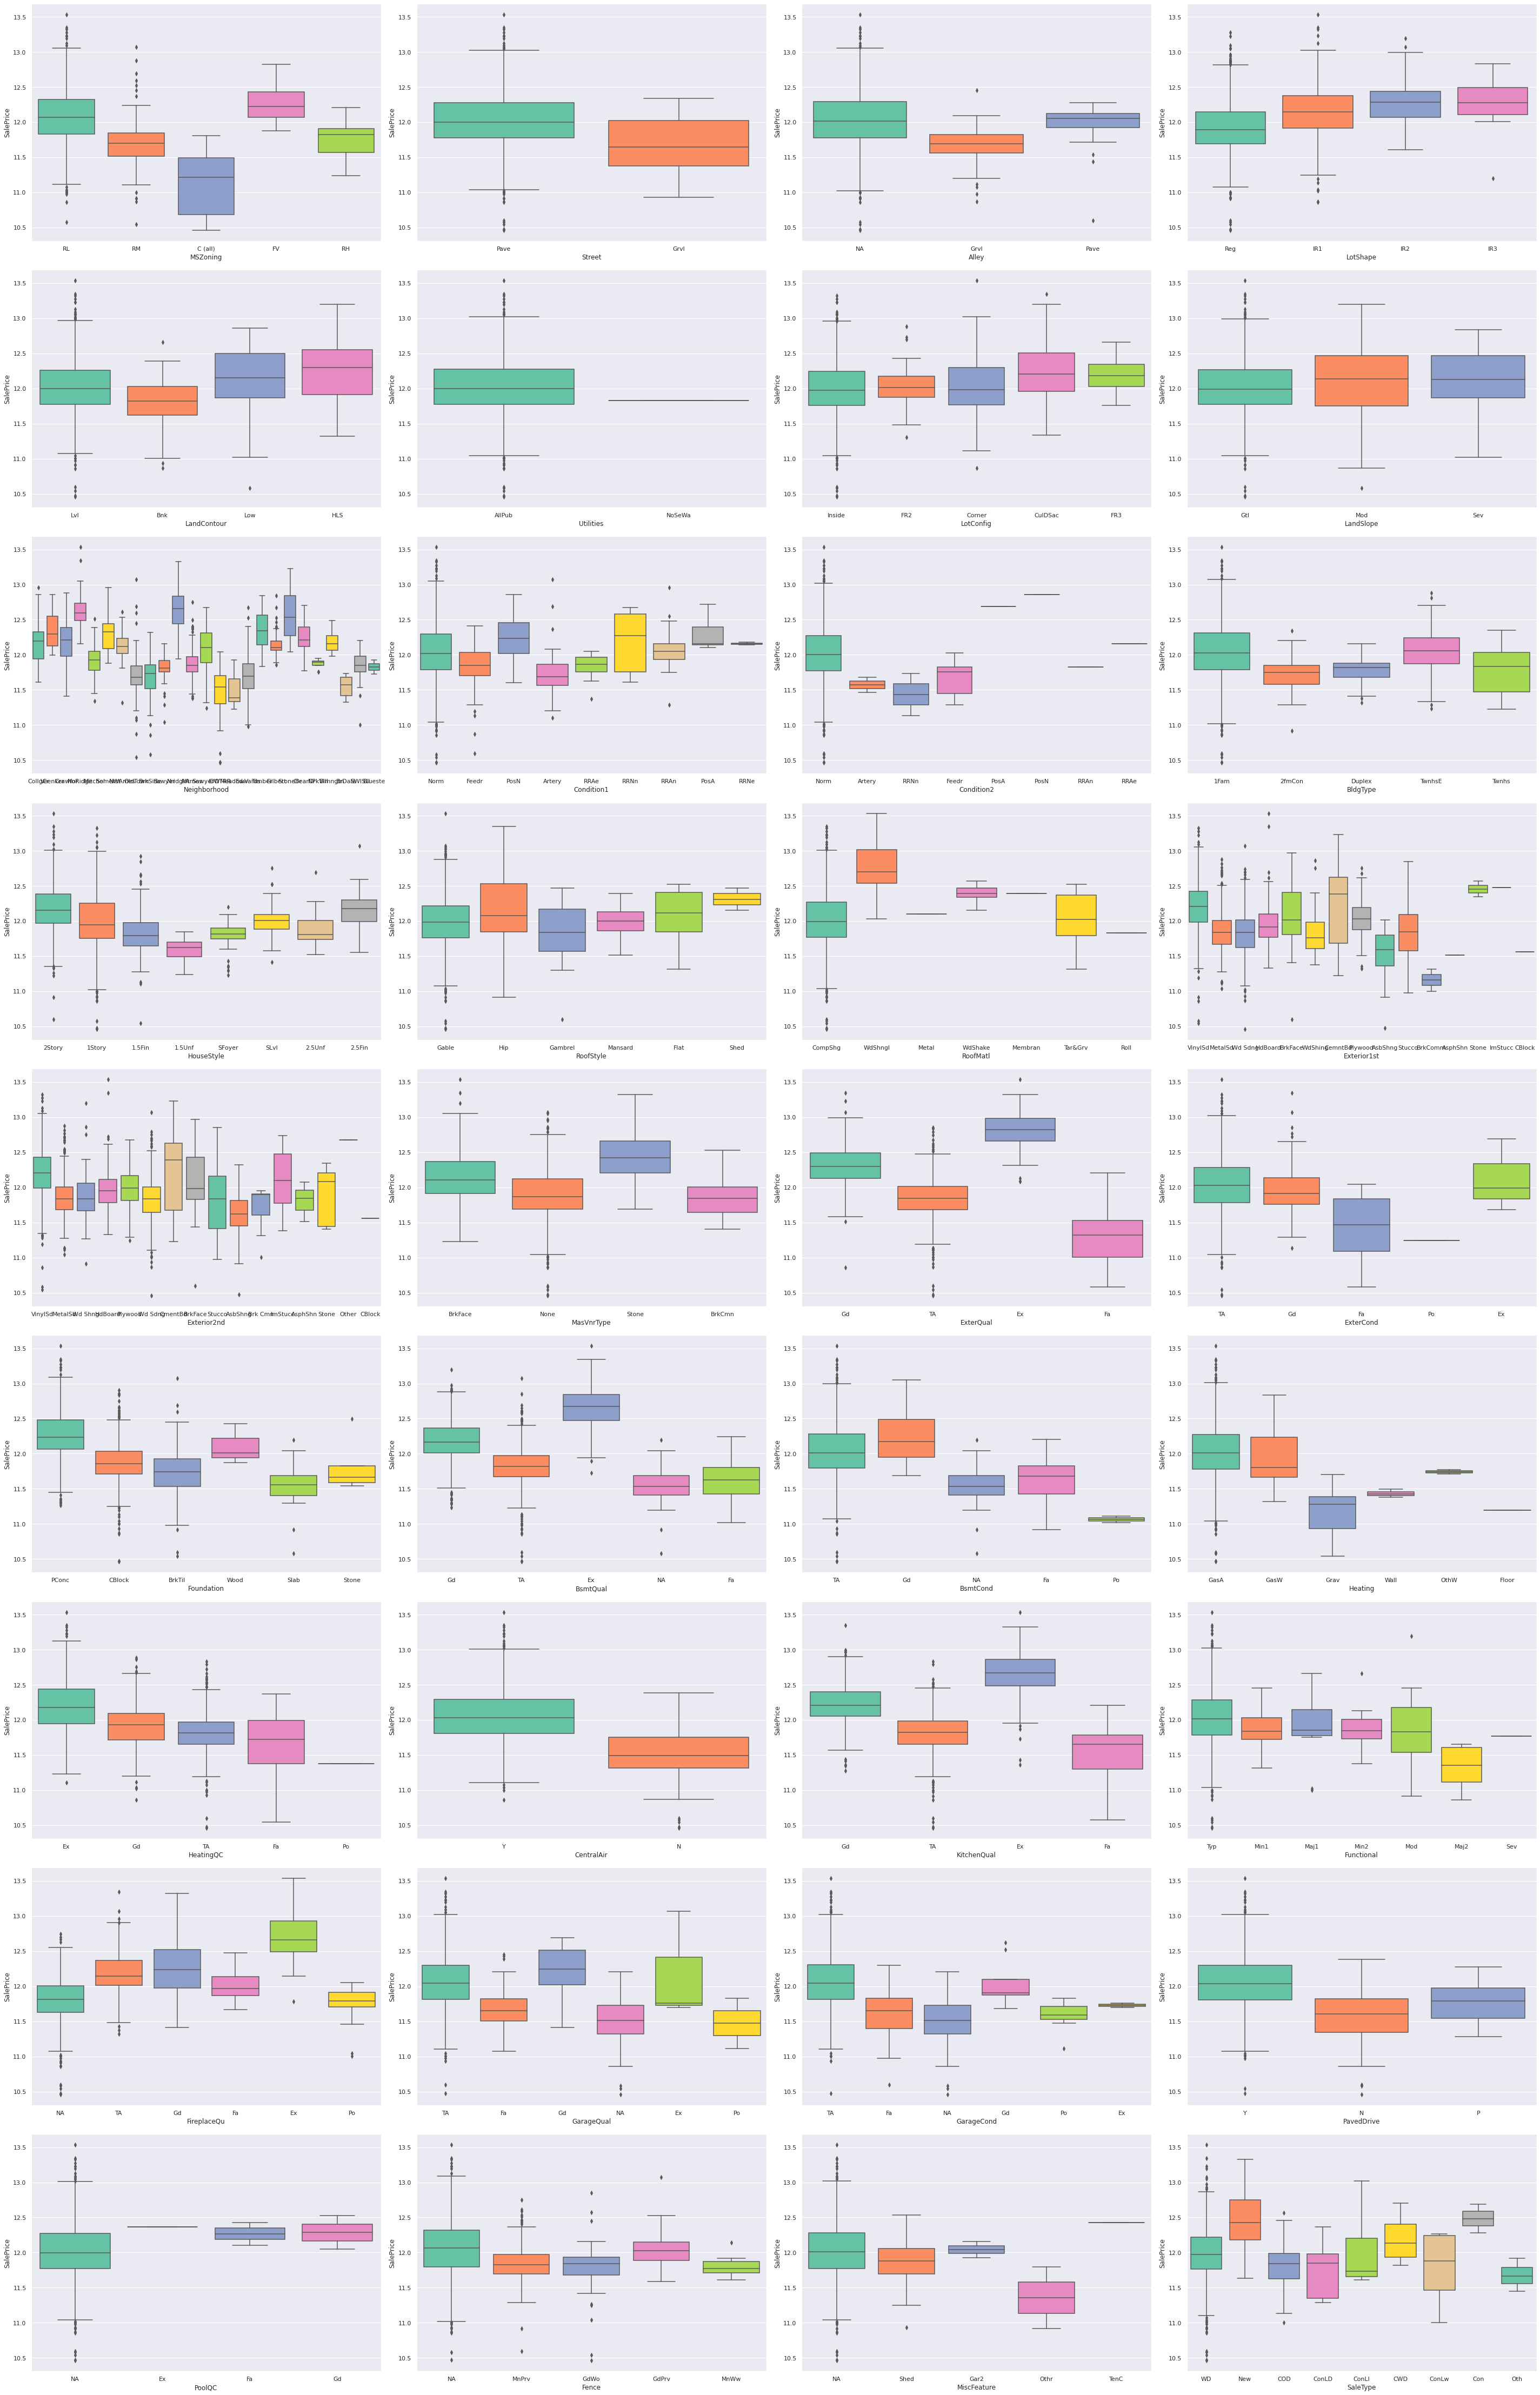

In [32]:
# Qualitative Analysis
# Creating a boxplot of all qualitative variable w.r.t. 'SalePrice'

fig, axes = plt.subplots(9, 4, figsize=(40, 62))
fig.tight_layout(pad=3)

cn=0
for i in range(9):
    for j in range(4):
        sns.boxplot(x = new_df[qualitative_data[cn]], y = new_df['SalePrice'], palette="Set2", saturation=1, ax = axes[i][j])
        cn += 1
        
plt.savefig('Qualitative Analysis.png')
plt.show()

<AxesSubplot:xlabel='Utilities', ylabel='SalePrice'>

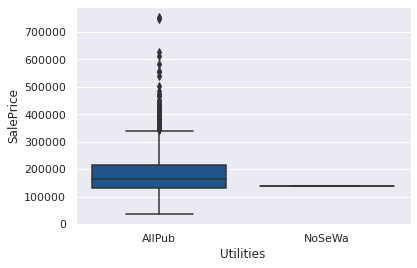

In [33]:
sns.boxplot(df_train.Utilities, df_train.SalePrice)

In [34]:
Neighplot1 = df_train.groupby(['Neighborhood']).LotArea.count().sort_values(ascending=True).to_frame(name = 'Count')
Neighplot2 = df_train.groupby(['Neighborhood']).SalePrice.median().sort_values(ascending=True).to_frame(name = 'Price')
Neighplot = Neighplot2.merge(Neighplot1,left_index=True, right_index=True)

Neighplot

,Price,Count
Neighborhood,,
MeadowV,88000,17
IDOTRR,103000,37
BrDale,106000,16
OldTown,119000,113
Edwards,121750,100
BrkSide,124300,58
Sawyer,135000,74
Blueste,137500,2
SWISU,139500,25


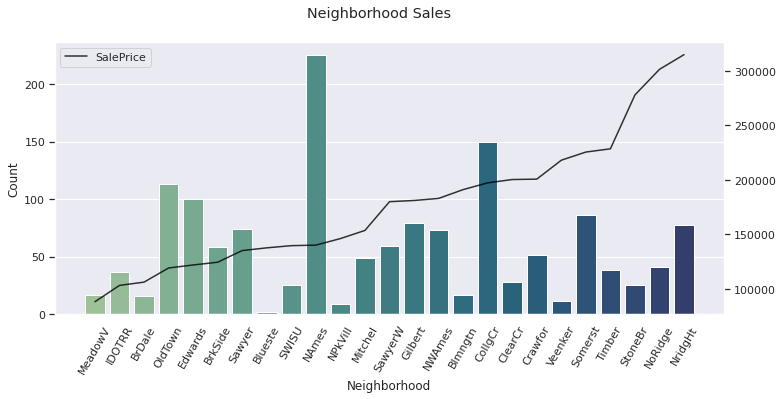

In [35]:
fig = plt.figure(figsize=(12,5))
sns.set()

ax1 = fig.add_subplot(111)

# Graph 1 displaying the frequency of neighborhood
pl = sns.barplot(x=Neighplot.index, y=Neighplot.Count, palette='crest', label='Frequency', ax=ax1)

ax2 = ax1.twinx()
# Graph 2 displaying Price for respective neighborhood
ax2.plot(Neighplot.Price, color='black', alpha=0.8, label='SalePrice')
ax2.grid(False)

plt.suptitle('Neighborhood Sales')
plt.setp(pl.get_xticklabels(), rotation=60)
plt.legend()
plt.show()

To find the strength of realtion between qualitative features and SalePrice we will perforn ANOVA test.

In [36]:
grouped_test = new_df[['Neighborhood', 'SalePrice']].groupby(['Neighborhood'])
# grouped_test.head()
grouped_test.nunique().index

Index(['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr',
       'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel',
       'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown', 'SWISU',
       'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker'],
      dtype='object', name='Neighborhood')

### ANOVA

Analysis of variance, or ANOVA, is a powerful statistical technique that involves partitioning the observed variance into different components to conduct various significance tests.

In [37]:
# ANOVA
drop_anova = []
create_qual_dummies = []

for count, col in enumerate(count_cols(new_df)[2].columns):
    grouped_test = new_df[[col, 'SalePrice']].groupby([col])

    ogt = []
    
    grouped_test_index = grouped_test[col].nunique().index
    
    for index in grouped_test_index:
        ogt.append(grouped_test.get_group(index)['SalePrice'])

    f_val, p_val = stats.f_oneway(*ogt)  
    
    if not(f_val > 80 and p_val < 0.001):
        drop_anova.append(col)
        continue
    create_qual_dummies.append(col)
    print(f"{count:2}. {col:15} :  F-stats = {f_val:20}  |  p-value = {p_val:25}  |  Accepted (F>70 & P<0.001)")
    for i in range(0, len(grouped_test_index)-1):
        for j in range(i+1, len(grouped_test_index)):
            f_val, p_val = stats.f_oneway(grouped_test.get_group(grouped_test_index[i])['SalePrice'], grouped_test.get_group(grouped_test_index[j])['SalePrice'])
            if p_val < 0.05 and f_val < 10:
                print(f"    >> {grouped_test_index[i]:8} & {grouped_test_index[j]:15} :  F-stats = {f_val:20}  |  p-value = {p_val:25}")

print("\nDrop rejected columns :", drop_anova)
print("\nCreate dummies for column :", create_qual_dummies)

 8. Neighborhood    :  F-stats =    80.21982356128693  |  p-value =    4.479220662367514e-244  |  Accepted (F>70 & P<0.001)
    >> Blmngtn  & Blueste         :  F-stats =    9.650830480197204  |  p-value =      0.006413478260866606
    >> Blmngtn  & Somerst         :  F-stats =    4.283876343234625  |  p-value =       0.04105337821365022
    >> Blmngtn  & Timber          :  F-stats =   7.9555521444273145  |  p-value =      0.006730822779173409
    >> Blmngtn  & Veenker         :  F-stats =    4.471655252891791  |  p-value =       0.04420576706641796
    >> Blueste  & BrDale          :  F-stats =   7.0955354854355255  |  p-value =      0.016985927705711258
    >> Blueste  & ClearCr         :  F-stats =    5.745026949281221  |  p-value =      0.023453732128673507
    >> Blueste  & Gilbert         :  F-stats =    8.287787562877668  |  p-value =      0.005133080135728655
    >> Blueste  & MeadowV         :  F-stats =    4.734462902274387  |  p-value =      0.043957828113153886
    >> Blues

In [38]:
new_df.drop(drop_anova, axis=1, inplace=True)

In [39]:
gradeof5 = {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
gradeof6 = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}

for col in ['ExterQual', 'HeatingQC', 'KitchenQual']:
    new_df[col].replace(gradeof5, inplace=True)
    create_qual_dummies.remove(col)

for col in ['FireplaceQu', 'BsmtQual']:
    new_df[col].replace(gradeof6, inplace=True)
    create_qual_dummies.remove(col)

new_df = pd.concat([new_df,pd.get_dummies(new_df[create_qual_dummies], drop_first=True)], axis=1)
new_df.drop(create_qual_dummies, axis=1, inplace=True)

In [40]:
count_cols(new_df)[0]

'There are 89 numeric columns and 0 categorical columns.'

In [41]:
new_df.to_csv('output/dataset/Housing clean test_dataset.csv', index_label=False)